In [3]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

# 指定亂數種子
seed = 7
np.random.seed(seed)

# 載入資料集
(x_train, _), (x_test, _) = mnist.load_data()

# 轉換成 4D 張量
x_train_new = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_test_new = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')

# 因為是固定範圍, 所以執行正規化, 從 0-255 至 0-1
x_train_norm = x_train_new / 255
x_test_norm = x_test_new / 255

# 替圖片製造雜訊
nf = 0.5
size_train = x_train_norm.shape
x_train_noisy = x_train_norm + nf*np.random.normal(loc=0.0, scale=1.0, size=size_train)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

size_test = x_test_norm.shape
x_test_noisy = x_test_norm + nf*np.random.normal(loc=0.0, scale=1.0, size=size_test)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# 定義 autoencoder 模型
input_img = Input(shape=(28,28,1))
x = Conv2D(16, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)

encoded = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(16, (3,3), activation='relu')(x)
x = UpSampling2D((2,2))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded, name='autoencoder')
autoencoder.summary()   # 顯示模型摘要資訊

# 定義 encoder 模型
encoder = Model(input_img, encoded, name='encoder')
encoder.summary()    # 顯示模型摘要資訊

# 定義 decoder 模型
decoder_input = Input(shape=(4,4,8))
decoder_layer = autoencoder.layers[-7](decoder_input)
decoder_layer = autoencoder.layers[-6](decoder_layer)
decoder_layer = autoencoder.layers[-5](decoder_layer)
decoder_layer = autoencoder.layers[-4](decoder_layer)
decoder_layer = autoencoder.layers[-3](decoder_layer)
decoder_layer = autoencoder.layers[-2](decoder_layer)
decoder_layer = autoencoder.layers[-1](decoder_layer)
decoder = Model(decoder_input, decoder_layer, name='decoder')
decoder.summary()   # 顯示模型摘要資訊


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 7, 7, 8)           

Epoch 1/10
469/469 - 4s - loss: 0.2425 - accuracy: 0.7971 - val_loss: 0.1888 - val_accuracy: 0.7948 - 4s/epoch - 8ms/step
Epoch 2/10
469/469 - 3s - loss: 0.1770 - accuracy: 0.7985 - val_loss: 0.1662 - val_accuracy: 0.7997 - 3s/epoch - 5ms/step
Epoch 3/10
469/469 - 3s - loss: 0.1625 - accuracy: 0.8017 - val_loss: 0.1562 - val_accuracy: 0.8013 - 3s/epoch - 5ms/step
Epoch 4/10
469/469 - 2s - loss: 0.1542 - accuracy: 0.8036 - val_loss: 0.1504 - val_accuracy: 0.8013 - 2s/epoch - 5ms/step
Epoch 5/10
469/469 - 2s - loss: 0.1488 - accuracy: 0.8047 - val_loss: 0.1457 - val_accuracy: 0.8028 - 2s/epoch - 5ms/step
Epoch 6/10
469/469 - 2s - loss: 0.1450 - accuracy: 0.8054 - val_loss: 0.1422 - val_accuracy: 0.8062 - 2s/epoch - 5ms/step
Epoch 7/10
469/469 - 3s - loss: 0.1419 - accuracy: 0.8060 - val_loss: 0.1390 - val_accuracy: 0.8055 - 3s/epoch - 5ms/step
Epoch 8/10
469/469 - 3s - loss: 0.1394 - accuracy: 0.8065 - val_loss: 0.1374 - val_accuracy: 0.8050 - 3s/epoch - 5ms/step
Epoch 9/10
469/469 - 3s 

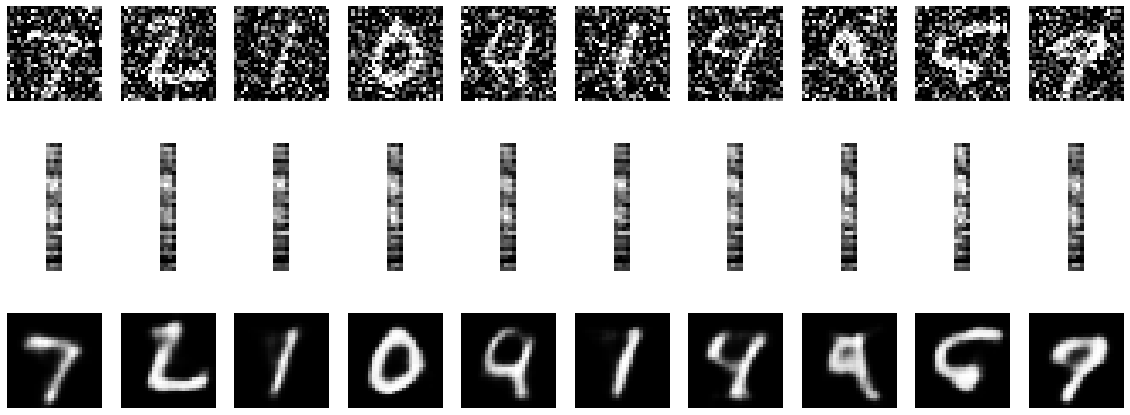

In [ ]:
# 編譯模型
autoencoder.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 訓練模型
autoencoder.fit(x_train_noisy, x_train_norm,
                validation_data=(x_test_noisy, x_test_norm),
                epochs=10, batch_size=128, shuffle=True, verbose=2)

# 壓縮圖片
encoded_imgs = encoder.predict(x_test_noisy)

# 解壓縮圖片
decoded_imgs = decoder.predict(encoded_imgs)

# 顯示雜訊圖片, 壓縮圖片和還原圖片
import matplotlib.pyplot as plt

n = 10  # 顯示幾個數字
plt.figure(figsize=(20, 8))
for i in range(n):
    # 雜訊圖片
    ax = plt.subplot(3, n, i + 1)
    ax.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
    # 壓縮圖片
    ax = plt.subplot(3, n, i + 1 + n)
    ax.imshow(encoded_imgs[i].reshape(4, 4*8).T, cmap='gray')
    ax.axis('off')
    # 還原圖片
    ax = plt.subplot(3, n, i + 1 + 2*n)
    ax.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

plt.show()


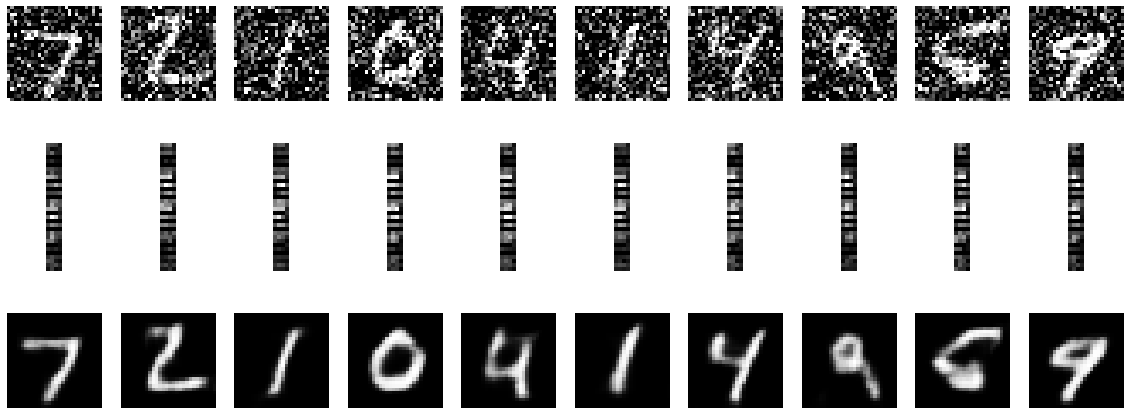

In [ ]:
# test

size_test = x_test_norm.shape
x_test_noisy = x_test_norm + nf*np.random.normal(loc=0.0, scale=1.0, size=size_test)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


# 壓縮圖片
encoded_imgs = encoder.predict(x_test_noisy)

# 解壓縮圖片
decoded_imgs = decoder.predict(encoded_imgs)

# 顯示雜訊圖片, 壓縮圖片和還原圖片
import matplotlib.pyplot as plt

n = 10  # 顯示幾個數字
plt.figure(figsize=(20, 8))
for i in range(n):
    # 雜訊圖片
    ax = plt.subplot(3, n, i + 1)
    ax.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
    # 壓縮圖片
    ax = plt.subplot(3, n, i + 1 + n)
    ax.imshow(encoded_imgs[i].reshape(4, 4*8).T, cmap='gray')
    ax.axis('off')
    # 還原圖片
    ax = plt.subplot(3, n, i + 1 + 2*n)
    ax.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

plt.show()
